# **Data Preprocessing**

## *Import libraries*

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
import pandas as pd
from PIL import Image
from glob import glob
import random

import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import os
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn


from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## *Data overview*

In [3]:
# Number of images

animals_list = os.listdir("animal/")
animals_file_list = []
total = 0
for i in range(len(animals_list)):
  animals_file_list.append(os.listdir(str("animal/" + animals_list[i])))
  n = len(animals_file_list[i])
  total+=n
  print(animals_list[i],":" ,n, 'images.')
print('Total:',total,'images.')

bee : 2531 images.
butterfly : 3489 images.
cat : 4384 images.
chicken : 3098 images.
cow : 2130 images.
dog : 4937 images.
eagle : 2504 images.
elephant : 3047 images.
horse : 3023 images.
human : 3817 images.
lion : 2513 images.
lizard : 2597 images.
monkey : 2049 images.
panther : 2772 images.
shark : 2244 images.
sheep : 2800 images.
spider : 4819 images.
squirrel : 3087 images.
tiger : 2882 images.
turtle : 2184 images.
Total: 60907 images.


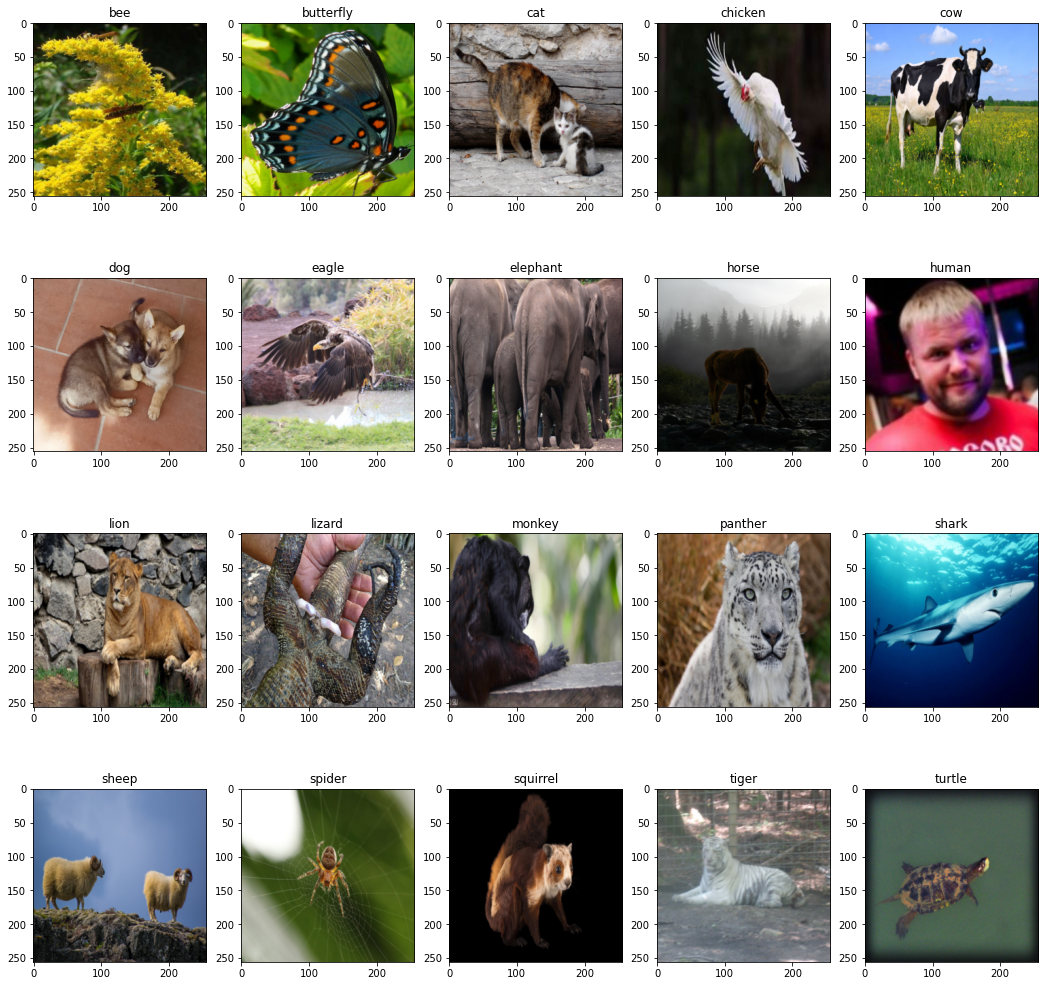

In [4]:
#Show some images

fig=plt.figure(figsize=(18,18))
columns = 5
rows = 4

for i in range(len(animals_list)):
    img = mpimg.imread(str("animal/"+ animals_list[i] + "/"+ animals_file_list[i][np.random.randint(0,len(animals_list[i]))]))
    compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256))])     #Resize images to 256x56
    img = compose(img)
    fig.add_subplot(rows, columns,i+1)
    plt.axis('on')
    plt.title(animals_list[i])
    plt.imshow(img)
plt.show()




## *Data preprocessing*

In [5]:
dir = 'animal'
files = [f for f in glob(dir + "**/**", recursive=True)] # create a list will allabsolute path of all files
files[0:10]

['animal\\',
 'animal\\bee',
 'animal\\bee\\0077S2N2GULV - Copy.jpg',
 'animal\\bee\\0077S2N2GULV.jpg',
 'animal\\bee\\008LE2H2WE50 - Copy.jpg',
 'animal\\bee\\008LE2H2WE50.jpg',
 'animal\\bee\\00OU0I1UKU3L - Copy.jpg',
 'animal\\bee\\00OU0I1UKU3L.jpg',
 'animal\\bee\\01PFIO79KYQC - Copy.jpg',
 'animal\\bee\\01PFIO79KYQC.jpg']

In [6]:
label = []
path = []
files = []
for d, _, filenames in os.walk(dir):
  for file in filenames:
    label.append(os.path.split(d)[1])
    path.append(os.path.join(d, file))
    files.append(os.path.join(file))

df_animals = pd.DataFrame(columns=['file_path','animal','file'])
df_animals['file_path'] = path
df_animals['animal'] = label
df_animals['file'] = files

In [7]:
df_animals

file_path  animal                     file
0      animal\bee\0077S2N2GULV - Copy.jpg     bee  0077S2N2GULV - Copy.jpg
1             animal\bee\0077S2N2GULV.jpg     bee         0077S2N2GULV.jpg
2      animal\bee\008LE2H2WE50 - Copy.jpg     bee  008LE2H2WE50 - Copy.jpg
3             animal\bee\008LE2H2WE50.jpg     bee         008LE2H2WE50.jpg
4      animal\bee\00OU0I1UKU3L - Copy.jpg     bee  00OU0I1UKU3L - Copy.jpg
...                                   ...     ...                      ...
60902         animal\turtle\Image_994.jpg  turtle            Image_994.jpg
60903         animal\turtle\Image_995.jpg  turtle            Image_995.jpg
60904         animal\turtle\Image_996.jpg  turtle            Image_996.jpg
60905         animal\turtle\Image_997.jpg  turtle            Image_997.jpg
60906        animal\turtle\Image_999.jpeg  turtle           Image_999.jpeg

[60907 rows x 3 columns]

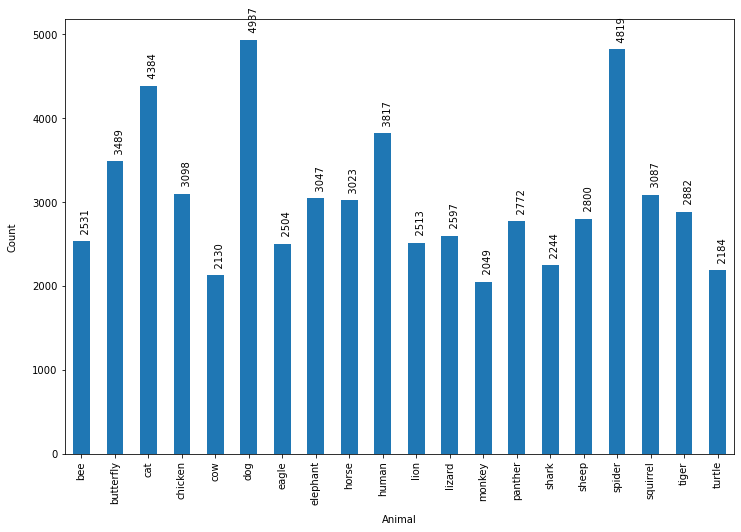

In [12]:
count_animal = df_animals['animal'].value_counts().sort_index()
# plt.rcParams['figure.figsize'] = (20, 7)
plt.xlabel('Animal', labelpad = 10)
plt.ylabel('Count', labelpad = 15)
for index, value in enumerate(count_animal.values):
    plt.text(index, value, '   ' + str(value), rotation = 90)
count_animal.plot.bar()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

In [8]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [9]:
# Reading Dataset
image_datasets = ImageFolder(root= dir, transform=transform)

In [10]:
train_val_test_weight = [70,10,20]
num_train = int(total*train_val_test_weight[0]/100)
num_valid = int(total*train_val_test_weight[1]/100)
num_test = total - num_train - num_valid
train_ds, valid_ds, test_ds = torch.utils.data.random_split(image_datasets,(num_train, num_valid, num_test))
print(len(train_ds))
print(len(valid_ds))
print(len(test_ds))

42634
6090
12183


In [11]:
num_workers = 0
batch_size = 32

loaders_scratch = {
    'train' : DataLoader(train_ds, shuffle = True, batch_size = batch_size),
    'valid' : DataLoader(valid_ds, shuffle = True, batch_size = batch_size),
    'test' : DataLoader(test_ds, shuffle = True, batch_size = batch_size)    
}

In [12]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
torch.cuda.is_available()

True

In [13]:
class_names = image_datasets.classes
num_class = len(class_names)
num_class

20

# Model

## *Scratch*

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 122 x 122 x 16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28 x 28 x 64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14 x 14 x 128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(p = 0.5, inplace = True)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        # linear layer
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128,num_class)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn5(self.pool(F.relu(self.conv4(x))))
        x = self.conv_bn6(self.pool(F.relu(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256*7*7)
        # add dropout layer
        x = self.dropout(x)
        # add 4 hidden layers, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        # add 5th hidden layer, with relu activation function
        x = self.fc4(x)
        return x

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=True)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6):

In [16]:
# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = torch.optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, writer):

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor= 0.3, patience=2, verbose=True)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0
        total = 0
        valid_acc = 0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            data, target = data.cpu(), target.cpu()


            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)
            
            pred_val = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred_val.eq(target.data.view_as(pred_val))).cpu().numpy())
            total += data.size(0)
            
            data, target = data.cpu(), target.cpu()
        scheduler.step(valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        valid_acc = 100 * correct / total
        print('Validation Accuracy: %2d%% (%2d/%2d)' % (valid_acc, correct, total))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        writer.add_scalar('training loss', train_loss, epoch * len(loaders['train']) + batch_idx)
        writer.add_scalar('validation loss', valid_loss, epoch * len(loaders['valid']) + batch_idx)
        writer.add_scalar('Validation accuracy', 100 * correct / total, epoch)
            
    # return trained model
    return model

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    if torch.cuda.is_available():
        model.cuda()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predict5ed class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        data, target = data.cpu(), target.cpu()
            
    print('\nTest Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    model.cpu()

In [19]:
def train_and_test(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, summary_path = 'run/testTensor'):
    writer = SummaryWriter(summary_path)
    model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, writer)
    model.load_state_dict(torch.load(save_path))
    test(loaders, model, criterion, use_cuda)

In [44]:
save_path_scratch = 'model10/model_scratch1.pt'
n_epochs = 10
train_and_test(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, save_path_scratch,'run10/Scratch')

Epoch: 1 	Training Loss: 2.262336 	Validation Loss: 1.656861
Validation Accuracy: 48% (2936/6090)
Validation loss decreased (inf --> 1.656861).  Saving model ...
Epoch: 2 	Training Loss: 1.554705 	Validation Loss: 1.263336
Validation Accuracy: 61% (3718/6090)
Validation loss decreased (1.656861 --> 1.263336).  Saving model ...
Epoch: 3 	Training Loss: 1.261328 	Validation Loss: 1.075592
Validation Accuracy: 66% (4023/6090)
Validation loss decreased (1.263336 --> 1.075592).  Saving model ...
Epoch: 4 	Training Loss: 1.061568 	Validation Loss: 0.934426
Validation Accuracy: 70% (4270/6090)
Validation loss decreased (1.075592 --> 0.934426).  Saving model ...
Epoch: 5 	Training Loss: 0.919416 	Validation Loss: 0.900283
Validation Accuracy: 72% (4394/6090)
Validation loss decreased (0.934426 --> 0.900283).  Saving model ...
Epoch: 6 	Training Loss: 0.800826 	Validation Loss: 0.826227
Validation Accuracy: 73% (4484/6090)
Validation loss decreased (0.900283 --> 0.826227).  Saving model ...
Epo

## *VGG16*

In [20]:
import torchvision.models as models
import torch.nn as nn

model_VGG16 = models.vgg16(pretrained = True)

for param in model_VGG16.features.parameters():
    param.requires_grad = False

n_inputs = model_VGG16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, num_class)
model_VGG16.classifier[6] = last_layer


# if GPU is available, move the model to GPU
if use_cuda:
    model_VGG16.cuda()
print(model_VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
loaders_VGG = loaders_scratch
criterion_VGG = nn.CrossEntropyLoss()
optimizer_VGG = optim.SGD(model_VGG16.classifier.parameters(), lr=0.001)
save_path_VGG = 'model10/model_VGG1.pt'


In [47]:
# train the model
n_epochs = 10
train_and_test(n_epochs, loaders_VGG, model_VGG16, optimizer_VGG, criterion_VGG, use_cuda, save_path_VGG,'run10/VGG16')

Epoch: 1 	Training Loss: 0.493125 	Validation Loss: 0.183508
Validation Accuracy: 95% (5813/6090)
Validation loss decreased (inf --> 0.183508).  Saving model ...
Epoch: 2 	Training Loss: 0.189661 	Validation Loss: 0.151660
Validation Accuracy: 95% (5842/6090)
Validation loss decreased (0.183508 --> 0.151660).  Saving model ...
Epoch: 3 	Training Loss: 0.159750 	Validation Loss: 0.137246
Validation Accuracy: 96% (5869/6090)
Validation loss decreased (0.151660 --> 0.137246).  Saving model ...
Epoch: 4 	Training Loss: 0.144704 	Validation Loss: 0.131804
Validation Accuracy: 96% (5877/6090)
Validation loss decreased (0.137246 --> 0.131804).  Saving model ...
Epoch: 5 	Training Loss: 0.131609 	Validation Loss: 0.124089
Validation Accuracy: 96% (5886/6090)
Validation loss decreased (0.131804 --> 0.124089).  Saving model ...
Epoch: 6 	Training Loss: 0.124711 	Validation Loss: 0.121960
Validation Accuracy: 96% (5884/6090)
Validation loss decreased (0.124089 --> 0.121960).  Saving model ...
Epo

## *ResNet*

In [22]:
import torchvision.models as models
import torch.nn as nn

model_ResNet = models.resnet34(pretrained = True)
model_ResNet.fc = nn.Linear(in_features=512, out_features=num_class, bias = True)
# if GPU is available, move the model to GPU
if use_cuda:
     model_ResNet.cuda()
print(model_ResNet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
loaders_ResNet = loaders_scratch
criterion_ResNet = nn.CrossEntropyLoss()
optimizer_ResNet = optim.SGD(model_ResNet.parameters(), lr=0.001)
save_path_ResNet = 'model10/model_ResNet1.pt'
n_epochs = 10

train_and_test(n_epochs, loaders_ResNet, model_ResNet, optimizer_ResNet, criterion_ResNet, use_cuda, save_path_ResNet, 'run/ResNet34_10')

Epoch: 1 	Training Loss: 0.807934 	Validation Loss: 0.210969
Validation Accuracy: 96% (5861/6090)
Validation loss decreased (inf --> 0.210969).  Saving model ...
Epoch: 2 	Training Loss: 0.219229 	Validation Loss: 0.130747
Validation Accuracy: 97% (5913/6090)
Validation loss decreased (0.210969 --> 0.130747).  Saving model ...
Epoch: 3 	Training Loss: 0.158432 	Validation Loss: 0.106485
Validation Accuracy: 97% (5924/6090)
Validation loss decreased (0.130747 --> 0.106485).  Saving model ...
Epoch: 4 	Training Loss: 0.127235 	Validation Loss: 0.092573
Validation Accuracy: 97% (5943/6090)
Validation loss decreased (0.106485 --> 0.092573).  Saving model ...
Epoch: 5 	Training Loss: 0.106751 	Validation Loss: 0.083223
Validation Accuracy: 97% (5956/6090)
Validation loss decreased (0.092573 --> 0.083223).  Saving model ...
Epoch: 6 	Training Loss: 0.093156 	Validation Loss: 0.079719
Validation Accuracy: 97% (5956/6090)
Validation loss decreased (0.083223 --> 0.079719).  Saving model ...
Epo

## *Squeezenet*

In [23]:
model_Squeeze = models.squeezenet1_1(pretrained=True)
model_Squeeze.classifier[1] = nn.Conv2d(512, num_class, kernel_size=(1,1), stride=(1,1))
if use_cuda:
     model_Squeeze.cuda()
print(model_Squeeze)
print(model_Squeeze.parameters())

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [21]:
loaders_Squeeze = loaders_scratch
criterion_Squeeze = nn.CrossEntropyLoss()
optimizer_Squeeze = optim.SGD(model_Squeeze.parameters(), lr=0.001)
save_path_Squeeze = 'model10/model_Squeeze1.pt'
n_epochs = 10


train_and_test(n_epochs, loaders_Squeeze, model_Squeeze, optimizer_Squeeze, criterion_Squeeze, use_cuda, save_path_Squeeze, 'run10/SqueezeNet')

Epoch: 1 	Training Loss: 0.730150 	Validation Loss: 0.424084
Validation Accuracy: 86% (5291/6090)
Validation loss decreased (inf --> 0.424084).  Saving model ...
Epoch: 2 	Training Loss: 0.348430 	Validation Loss: 0.321972
Validation Accuracy: 89% (5471/6090)
Validation loss decreased (0.424084 --> 0.321972).  Saving model ...
Epoch: 3 	Training Loss: 0.286983 	Validation Loss: 0.311955
Validation Accuracy: 90% (5500/6090)
Validation loss decreased (0.321972 --> 0.311955).  Saving model ...
Epoch: 4 	Training Loss: 0.252958 	Validation Loss: 0.272683
Validation Accuracy: 91% (5565/6090)
Validation loss decreased (0.311955 --> 0.272683).  Saving model ...
Epoch: 5 	Training Loss: 0.226851 	Validation Loss: 0.260745
Validation Accuracy: 91% (5584/6090)
Validation loss decreased (0.272683 --> 0.260745).  Saving model ...
Epoch: 6 	Training Loss: 0.207477 	Validation Loss: 0.230023
Validation Accuracy: 92% (5638/6090)
Validation loss decreased (0.260745 --> 0.230023).  Saving model ...
Epo

## *Alex Net*

In [24]:
model_AlexNet = models.alexnet(pretrained=True)
model_AlexNet.classifier[6] = nn.Linear(in_features=4096,out_features=num_class,bias=True)
if use_cuda:
     model_AlexNet.cuda()
print(model_AlexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
loaders_AlexNet = loaders_scratch
criterion_AlexNet = nn.CrossEntropyLoss()
optimizer_AlexNet = optim.SGD(model_AlexNet.parameters(), lr=0.001)
save_path_AlexNet = 'model10/model_Alex1.pt'
n_epochs = 10

train_and_test(n_epochs, loaders_AlexNet, model_AlexNet, optimizer_AlexNet, criterion_AlexNet, use_cuda, save_path_AlexNet, 'run10/AlexNet')

Epoch: 1 	Training Loss: 0.506469 	Validation Loss: 0.285072
Validation Accuracy: 91% (5563/6090)
Validation loss decreased (inf --> 0.285072).  Saving model ...
Epoch: 2 	Training Loss: 0.283734 	Validation Loss: 0.238135
Validation Accuracy: 92% (5644/6090)
Validation loss decreased (0.285072 --> 0.238135).  Saving model ...
Epoch: 3 	Training Loss: 0.237918 	Validation Loss: 0.219813
Validation Accuracy: 92% (5661/6090)
Validation loss decreased (0.238135 --> 0.219813).  Saving model ...
Epoch: 4 	Training Loss: 0.205964 	Validation Loss: 0.197651
Validation Accuracy: 93% (5714/6090)
Validation loss decreased (0.219813 --> 0.197651).  Saving model ...
Epoch: 5 	Training Loss: 0.185230 	Validation Loss: 0.189205
Validation Accuracy: 93% (5722/6090)
Validation loss decreased (0.197651 --> 0.189205).  Saving model ...
Epoch: 6 	Training Loss: 0.161501 	Validation Loss: 0.182723
Validation Accuracy: 94% (5741/6090)
Validation loss decreased (0.189205 --> 0.182723).  Saving model ...
Epo

## *Mobile Net V3*

In [25]:
model_MobileNetV3 = models.mobilenet_v3_small(pretrained=True)
model_MobileNetV3.classifier[3] = nn.Linear(in_features=1024, out_features=num_class)
# if GPU is available, move the model to GPU
if use_cuda:
     model_MobileNetV3.cuda()
print(model_MobileNetV3)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [25]:
loaders_MobileNetV3 = loaders_scratch
criterion_MobileNetV3 = nn.CrossEntropyLoss()
optimizer_MobileNetV3 = optim.SGD(model_MobileNetV3.parameters(), lr=0.001)
save_path_MobileNetV3 = 'model10/model_MobileNetV3_1.pt'
n_epochs = 10

train_and_test(n_epochs, loaders_MobileNetV3, model_MobileNetV3, optimizer_MobileNetV3, criterion_MobileNetV3, use_cuda, save_path_MobileNetV3, 'run10/MobileNetV3')

Epoch: 1 	Training Loss: 1.674450 	Validation Loss: 0.756667
Validation Accuracy: 87% (5338/6090)
Validation loss decreased (inf --> 0.756667).  Saving model ...
Epoch: 2 	Training Loss: 0.645006 	Validation Loss: 0.418930
Validation Accuracy: 91% (5565/6090)
Validation loss decreased (0.756667 --> 0.418930).  Saving model ...
Epoch: 3 	Training Loss: 0.437087 	Validation Loss: 0.314452
Validation Accuracy: 93% (5679/6090)
Validation loss decreased (0.418930 --> 0.314452).  Saving model ...
Epoch: 4 	Training Loss: 0.357082 	Validation Loss: 0.258715
Validation Accuracy: 93% (5705/6090)
Validation loss decreased (0.314452 --> 0.258715).  Saving model ...
Epoch: 5 	Training Loss: 0.312550 	Validation Loss: 0.228410
Validation Accuracy: 94% (5743/6090)
Validation loss decreased (0.258715 --> 0.228410).  Saving model ...
Epoch: 6 	Training Loss: 0.280592 	Validation Loss: 0.206980
Validation Accuracy: 94% (5770/6090)
Validation loss decreased (0.228410 --> 0.206980).  Saving model ...
Epo

## *Fine tune*

In [26]:
model_fineTune_squeezeNet = models.squeezenet1_1(pretrained=True)
model_fineTune_squeezeNet.classifier[1] = nn.Conv2d(512, num_class, kernel_size=(3,3), stride=(1,1))
model_fineTune_squeezeNet.classifier[0] = nn.Dropout(p = 0.5, inplace = True)
if use_cuda:
     model_fineTune_squeezeNet.cuda()
print(model_fineTune_squeezeNet)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [27]:
loaders_fineTune_squeezeNet = loaders_scratch
criterion_fineTune_squeezeNet = nn.CrossEntropyLoss()
optimizer_fineTune_squeezeNet = optim.SGD(model_fineTune_squeezeNet.parameters(), lr=0.001)
save_path_fineTune_squeezeNet = 'model10/model_finetune_Squeeze1.pt'
n_epochs = 10

train_and_test(n_epochs, loaders_fineTune_squeezeNet, model_fineTune_squeezeNet, optimizer_fineTune_squeezeNet, criterion_fineTune_squeezeNet, use_cuda, save_path_fineTune_squeezeNet, 'run10/fineTune_SqueezeNet')

Epoch: 1 	Training Loss: 0.431019 	Validation Loss: 0.265946
Validation Accuracy: 91% (5565/6090)
Validation loss decreased (inf --> 0.265946).  Saving model ...
Epoch: 2 	Training Loss: 0.246840 	Validation Loss: 0.259233
Validation Accuracy: 91% (5579/6090)
Validation loss decreased (0.265946 --> 0.259233).  Saving model ...
Epoch: 3 	Training Loss: 0.204600 	Validation Loss: 0.264795
Validation Accuracy: 91% (5583/6090)
Epoch: 4 	Training Loss: 0.178856 	Validation Loss: 0.240601
Validation Accuracy: 92% (5644/6090)
Validation loss decreased (0.259233 --> 0.240601).  Saving model ...
Epoch: 5 	Training Loss: 0.158409 	Validation Loss: 0.246600
Validation Accuracy: 92% (5627/6090)
Epoch: 6 	Training Loss: 0.143998 	Validation Loss: 0.203879
Validation Accuracy: 94% (5730/6090)
Validation loss decreased (0.240601 --> 0.203879).  Saving model ...
Epoch: 7 	Training Loss: 0.129610 	Validation Loss: 0.196418
Validation Accuracy: 93% (5710/6090)
Validation loss decreased (0.203879 --> 0.1

# Result

In [27]:
%tensorboard --logdir=run

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the animal that is predicted by the model.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import random
import re

# create a list with a class names
class_names = image_datasets.classes
class_names = [re.sub("\d{3}.", "", item) for item in class_names]
class_names = [re.sub("_", " ", item) for item in class_names]

def predict_breed_transfer(img, model):
    
    img_ts = img[0]
    img_ts.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_ts = Variable(img_ts) #The input to the network needs to be an autograd Variable

    if use_cuda:
        model.cuda()
        img_ts = Variable(img_ts.cuda())

    model.eval()
    output = model(img_ts) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()

    # Our prediction will be the index of the class label with the largest value.
    predict_index = output.data.numpy().argmax()
    true_index = img[1]

    predicted_breed = class_names[predict_index]
    true_breed = class_names[true_index]
    model.cpu()
    return (predicted_breed,true_breed)


In [38]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [33]:
ind_lst = [i for i in range(num_test)]
np.random.shuffle(ind_lst)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: spider
VGG16: spider
ResNet34: spider
AlexNet: spider
SqueezeNet: spider
Finetuned SqueezeNet: spider
True Animal: spider


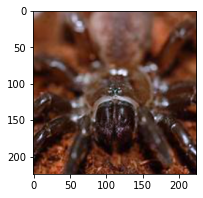

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: bee
VGG16: bee
ResNet34: bee
AlexNet: bee
SqueezeNet: bee
Finetuned SqueezeNet: bee
True Animal: bee


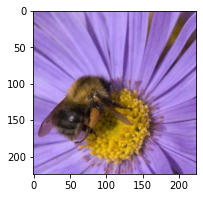

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: lizard
VGG16: panther
ResNet34: lizard
AlexNet: lizard
SqueezeNet: lizard
Finetuned SqueezeNet: lizard
True Animal: lizard


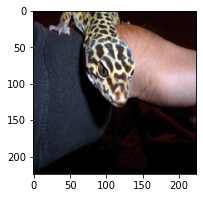

Scratch: bee
VGG16: bee
ResNet34: bee
AlexNet: bee
SqueezeNet: bee
Finetuned SqueezeNet: bee
True Animal: bee


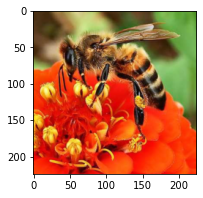

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: lion
VGG16: lion
ResNet34: lion
AlexNet: lion
SqueezeNet: lion
Finetuned SqueezeNet: lion
True Animal: lion


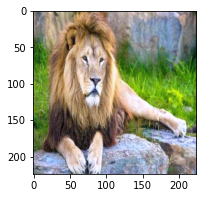

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: chicken
VGG16: chicken
ResNet34: chicken
AlexNet: chicken
SqueezeNet: chicken
Finetuned SqueezeNet: chicken
True Animal: chicken


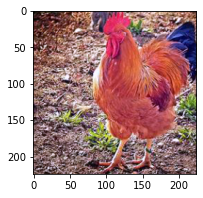

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: spider
VGG16: spider
ResNet34: spider
AlexNet: spider
SqueezeNet: spider
Finetuned SqueezeNet: spider
True Animal: spider


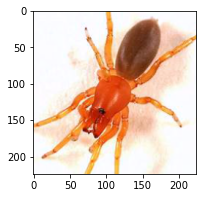

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: sheep
VGG16: sheep
ResNet34: sheep
AlexNet: sheep
SqueezeNet: sheep
Finetuned SqueezeNet: sheep
True Animal: sheep


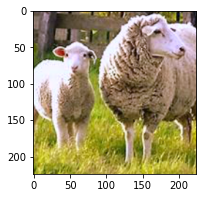

Scratch: elephant
VGG16: elephant
ResNet34: elephant
AlexNet: elephant
SqueezeNet: elephant
Finetuned SqueezeNet: elephant
True Animal: elephant


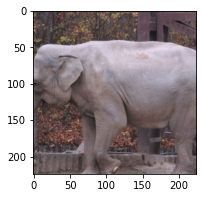

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: chicken
VGG16: chicken
ResNet34: chicken
AlexNet: chicken
SqueezeNet: chicken
Finetuned SqueezeNet: chicken
True Animal: chicken


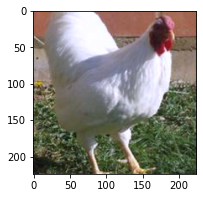

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: shark
VGG16: shark
ResNet34: shark
AlexNet: shark
SqueezeNet: shark
Finetuned SqueezeNet: shark
True Animal: shark


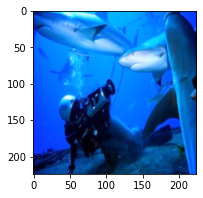

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: dog
VGG16: cow
ResNet34: cow
AlexNet: cow
SqueezeNet: cow
Finetuned SqueezeNet: cow
True Animal: cow


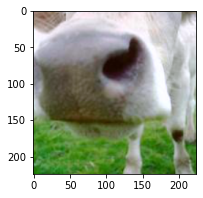

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: eagle
VGG16: eagle
ResNet34: eagle
AlexNet: eagle
SqueezeNet: eagle
Finetuned SqueezeNet: eagle
True Animal: eagle


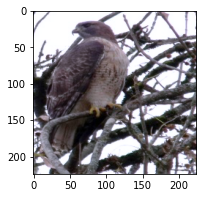

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: spider
VGG16: spider
ResNet34: spider
AlexNet: spider
SqueezeNet: spider
Finetuned SqueezeNet: spider
True Animal: spider


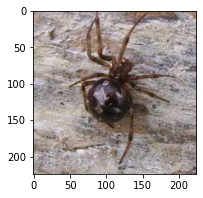

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: bee
VGG16: bee
ResNet34: bee
AlexNet: bee
SqueezeNet: bee
Finetuned SqueezeNet: bee
True Animal: bee


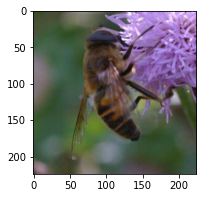

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: shark
VGG16: shark
ResNet34: shark
AlexNet: shark
SqueezeNet: shark
Finetuned SqueezeNet: shark
True Animal: shark


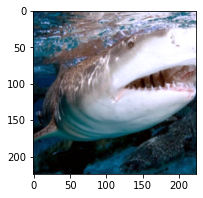

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: sheep
VGG16: sheep
ResNet34: sheep
AlexNet: sheep
SqueezeNet: sheep
Finetuned SqueezeNet: sheep
True Animal: sheep


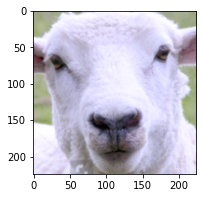

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: butterfly
VGG16: butterfly
ResNet34: butterfly
AlexNet: butterfly
SqueezeNet: butterfly
Finetuned SqueezeNet: butterfly
True Animal: butterfly


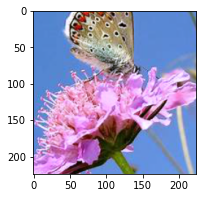

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: spider
VGG16: butterfly
ResNet34: butterfly
AlexNet: butterfly
SqueezeNet: butterfly
Finetuned SqueezeNet: butterfly
True Animal: butterfly


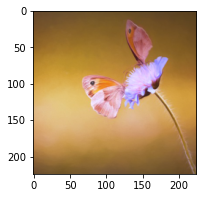

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: lizard
VGG16: lizard
ResNet34: lizard
AlexNet: lizard
SqueezeNet: lizard
Finetuned SqueezeNet: lizard
True Animal: lizard


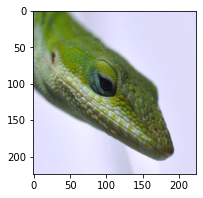

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: elephant
VGG16: elephant
ResNet34: elephant
AlexNet: elephant
SqueezeNet: elephant
Finetuned SqueezeNet: elephant
True Animal: elephant


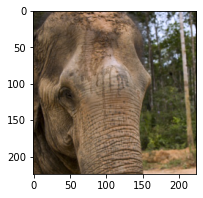

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: shark
VGG16: shark
ResNet34: shark
AlexNet: shark
SqueezeNet: shark
Finetuned SqueezeNet: shark
True Animal: shark


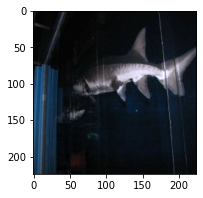

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: sheep
VGG16: sheep
ResNet34: sheep
AlexNet: sheep
SqueezeNet: sheep
Finetuned SqueezeNet: sheep
True Animal: sheep


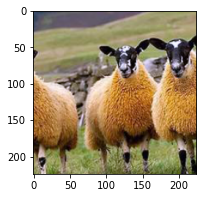

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: chicken
VGG16: chicken
ResNet34: chicken
AlexNet: chicken
SqueezeNet: chicken
Finetuned SqueezeNet: chicken
True Animal: chicken


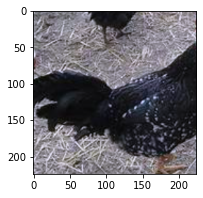

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: horse
VGG16: horse
ResNet34: horse
AlexNet: horse
SqueezeNet: horse
Finetuned SqueezeNet: horse
True Animal: horse


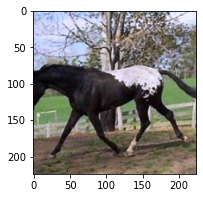

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: cow
VGG16: cow
ResNet34: cow
AlexNet: cow
SqueezeNet: cow
Finetuned SqueezeNet: cow
True Animal: cow


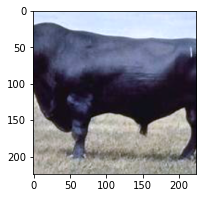

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: chicken
VGG16: chicken
ResNet34: chicken
AlexNet: chicken
SqueezeNet: chicken
Finetuned SqueezeNet: chicken
True Animal: chicken


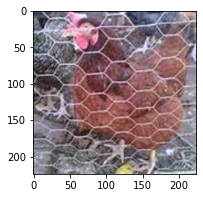

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: elephant
VGG16: elephant
ResNet34: elephant
AlexNet: elephant
SqueezeNet: elephant
Finetuned SqueezeNet: elephant
True Animal: elephant


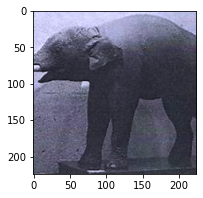

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: elephant
VGG16: elephant
ResNet34: elephant
AlexNet: elephant
SqueezeNet: elephant
Finetuned SqueezeNet: elephant
True Animal: elephant


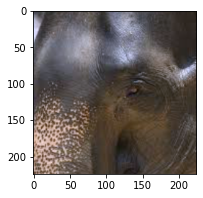

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: dog
VGG16: dog
ResNet34: dog
AlexNet: dog
SqueezeNet: dog
Finetuned SqueezeNet: dog
True Animal: dog


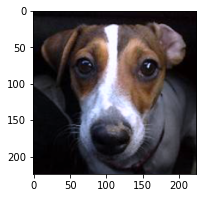

Scratch: turtle
VGG16: turtle
ResNet34: turtle
AlexNet: turtle
SqueezeNet: turtle
Finetuned SqueezeNet: turtle
True Animal: turtle


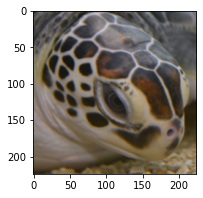

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: horse
VGG16: horse
ResNet34: horse
AlexNet: horse
SqueezeNet: horse
Finetuned SqueezeNet: horse
True Animal: horse


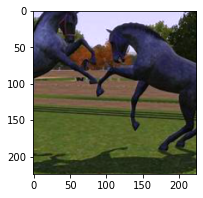

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: horse
VGG16: horse
ResNet34: horse
AlexNet: horse
SqueezeNet: horse
Finetuned SqueezeNet: horse
True Animal: horse


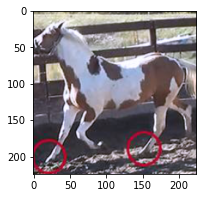

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: eagle
VGG16: eagle
ResNet34: eagle
AlexNet: eagle
SqueezeNet: eagle
Finetuned SqueezeNet: eagle
True Animal: eagle


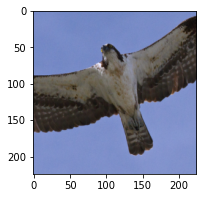

Scratch: spider
VGG16: spider
ResNet34: spider
AlexNet: spider
SqueezeNet: spider
Finetuned SqueezeNet: spider
True Animal: spider


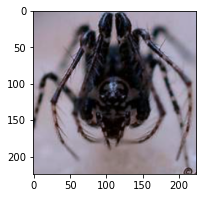

Scratch: spider
VGG16: spider
ResNet34: spider
AlexNet: spider
SqueezeNet: spider
Finetuned SqueezeNet: spider
True Animal: spider


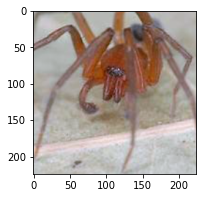

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: chicken
VGG16: chicken
ResNet34: chicken
AlexNet: chicken
SqueezeNet: chicken
Finetuned SqueezeNet: chicken
True Animal: chicken


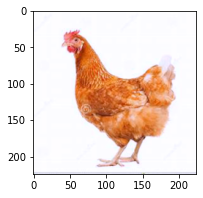

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: elephant
VGG16: elephant
ResNet34: elephant
AlexNet: elephant
SqueezeNet: elephant
Finetuned SqueezeNet: elephant
True Animal: elephant


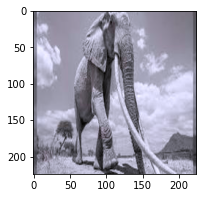

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: cow
VGG16: chicken
ResNet34: cow
AlexNet: cow
SqueezeNet: cow
Finetuned SqueezeNet: cow
True Animal: cow


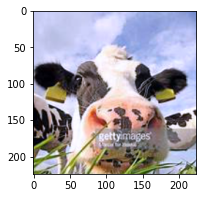

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scratch: monkey
VGG16: monkey
ResNet34: monkey
AlexNet: monkey
SqueezeNet: cat
Finetuned SqueezeNet: cat
True Animal: monkey


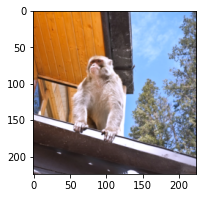

In [77]:
for i in range(40):
    
    predict_scratch, true = predict_breed_transfer(test_ds[ind_lst[i]], model_scratch)
    predict_VGG16 = predict_breed_transfer(test_ds[ind_lst[i]], model_VGG16)[0]
    predict_ResNet = predict_breed_transfer(test_ds[ind_lst[i]], model_ResNet)[0]
    predict_AlexNet = predict_breed_transfer(test_ds[ind_lst[i]], model_AlexNet)[0]
    predict_SqueezeNet = predict_breed_transfer(test_ds[ind_lst[i]], model_Squeeze)[0]
    predict_finetune_Squeeze = predict_breed_transfer(test_ds[ind_lst[i]], model_fineTune_squeezeNet)[0]
    
    print('Scratch:', predict_scratch)
    print('VGG16:',predict_VGG16)
    print('ResNet34:',predict_ResNet)
    print('AlexNet:',predict_ResNet)
    print('SqueezeNet:',predict_SqueezeNet)
    print('Finetuned SqueezeNet:',predict_finetune_Squeeze)
    print('======================')
    print('True Animal:',true)
    
    img = np.transpose(inv_normalize(test_ds[ind_lst[i]][0]), (1, 2, 0))
    img = np.array(img, dtype = 'float')
    plt.rcParams['figure.figsize'] = (3, 3)
    plt.imshow(img)
    plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

def confusion(model):
    y_predict = []
    y_true = []
    for i in range(num_test):
        predict_scratch, true = predict_breed_transfer(test_ds[ind_lst[i]], model)
        y_predict.append(predict_scratch)
        y_true.append(true)
    cf_matrix = confusion_matrix(y_true, y_predict)
    return cf_matrix

In [29]:
import seaborn as sns
def sketch_confusion(cf_matrix):
    class_names = image_datasets.classes
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    ## Display the visualization of the Confusion Matrix.
    plt.rcParams['figure.figsize'] = (20, 20)
    plt.show()

In [34]:
model_scratch.load_state_dict(torch.load('model30/model_scratch.pt'))
cf_matrix = confusion(model_scratch)  


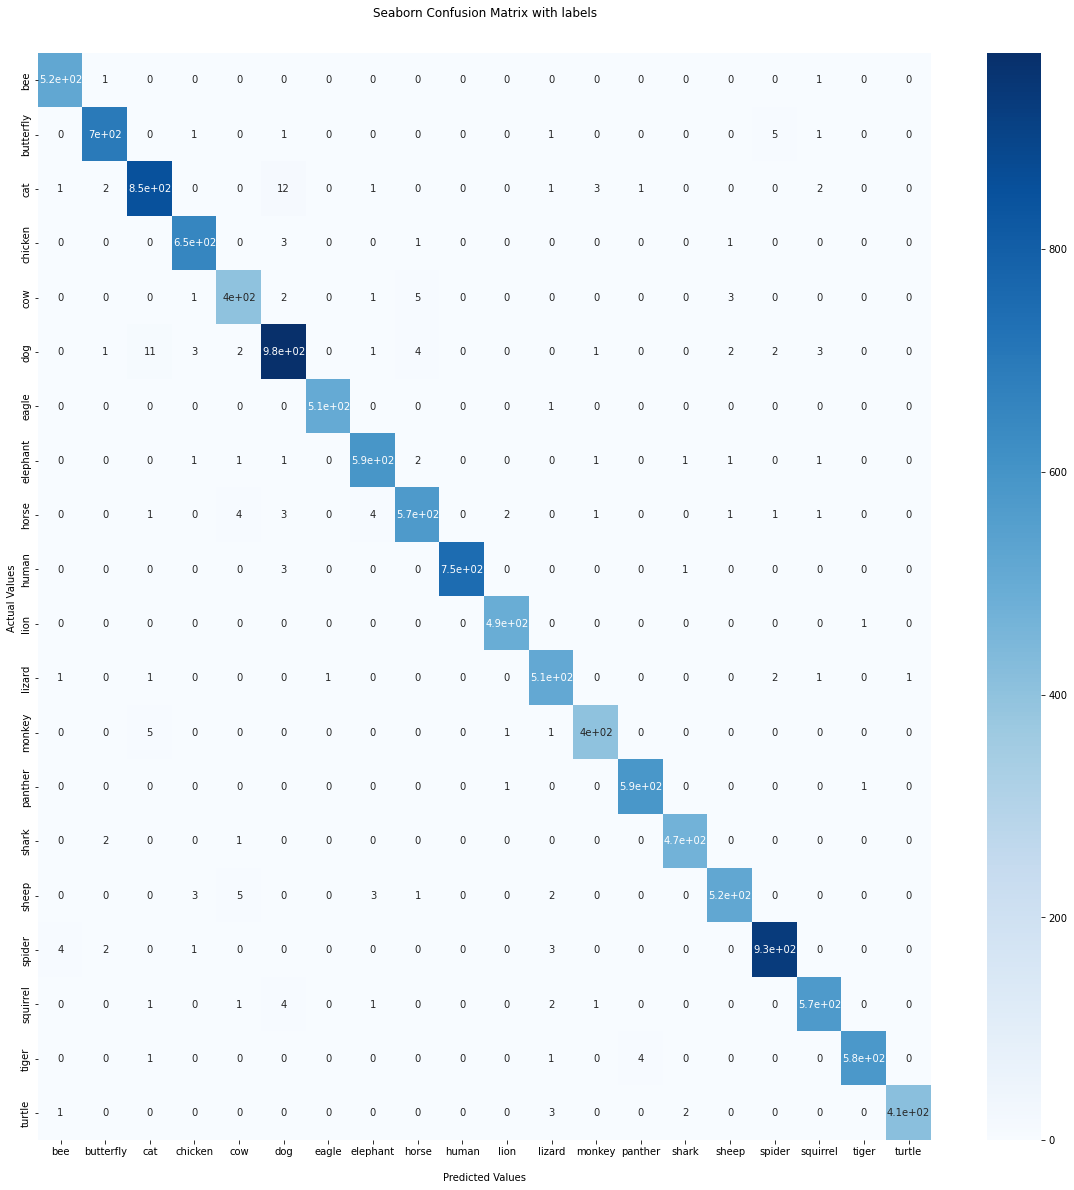

In [36]:
sketch_confusion(cf_matrix)

In [24]:
from prettytable import PrettyTable

from torchvision import models
from torchsummary import summary

summary(model_ResNet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

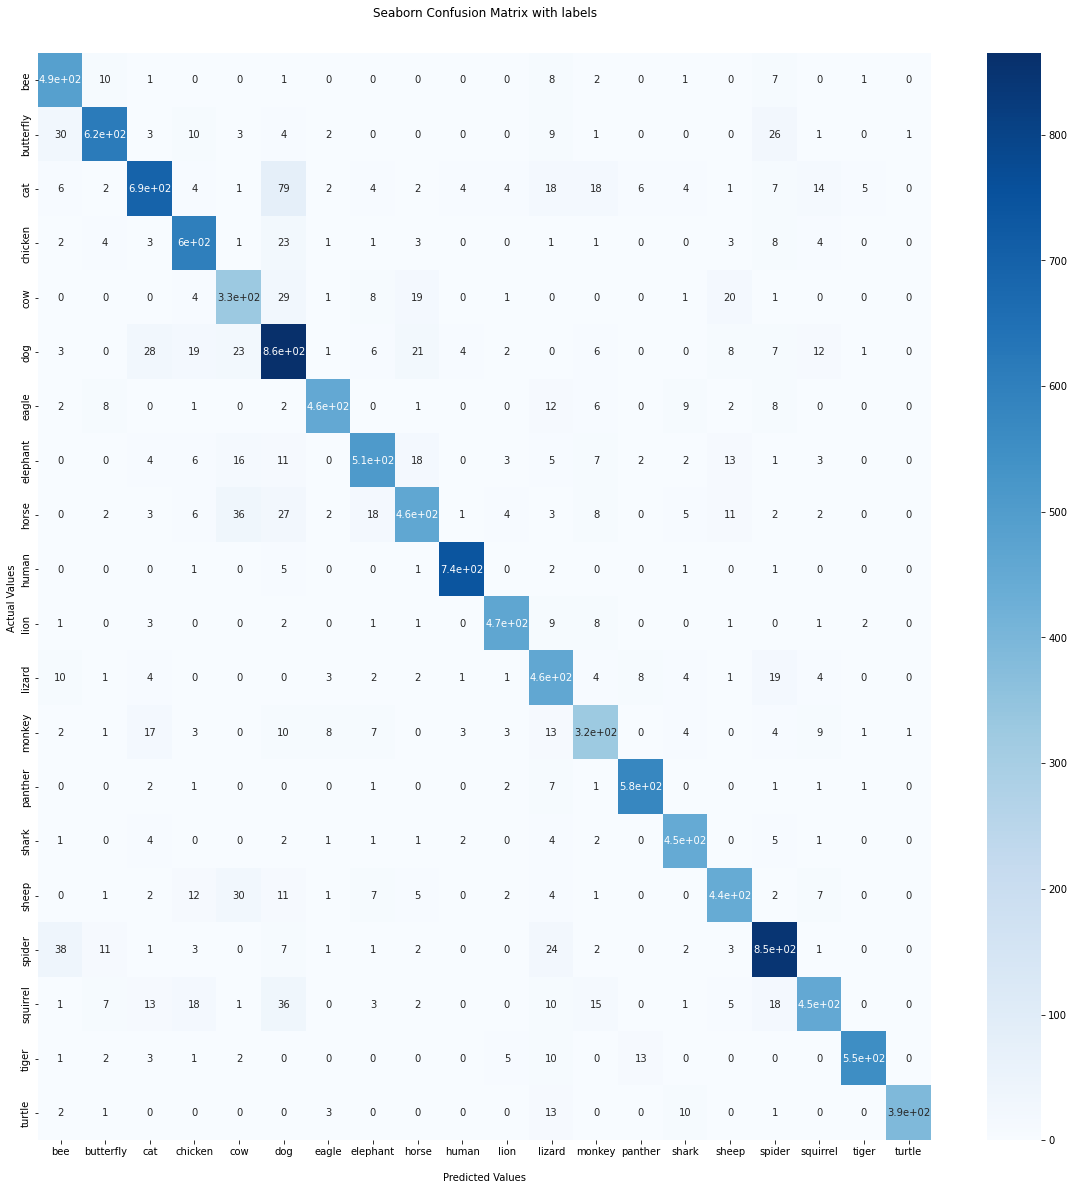

In [38]:
model_scratch.load_state_dict(torch.load('model10/model_scratch1.pt'))
cf_matrix = confusion(model_scratch)
sketch_confusion(cf_matrix)

In [40]:
model_MobileNetV3.load_state_dict(torch.load('model30/model_MobileNetV3.pt'))

<All keys matched successfully>

In [41]:
loaders_MobileNetV3 = loaders_scratch
criterion_MobileNetV3 = nn.CrossEntropyLoss()
optimizer_MobileNetV3 = optim.SGD(model_MobileNetV3.parameters(), lr=0.001)
save_path_MobileNetV3 = 'model10/model_MobileNetV3_1.pt'
n_epochs = 10
test(loaders_MobileNetV3, model_MobileNetV3, criterion_MobileNetV3, use_cuda)


Test Loss: 0.087669
Test Accuracy: 97% (11899/12183)
